# Install library

In [1]:
import os
import random

import numpy as np
import pandas as pd
import optuna

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from tensorflow.keras.layers import Input, Dense, Conv2D, Activation
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [2]:
def set_randvalue(value):
    # Set a seed value
    seed_value= value 
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)
    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)
    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(seed_value)

set_randvalue(42)

## Dataset preprocessing and EDA

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() # load data
x_train,x_test = x_train.astype('float32')/255.0,x_test.astype('float32')/255.0 # normalization
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [4]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [5]:
# No method on keras to get cifar10 category label name by categoly label?
cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

bird_ind = np.where(cifar10_labels=='bird')
deer_ind = np.where(cifar10_labels=='deer')
truck_ind = np.where(cifar10_labels=='truck')

In [6]:
remove_num = 2500
counter = 0
train_num = len(y_train) - remove_num * 3 # for 3 classes
x_train_removed =  np.zeros(x_train.shape)[:train_num]
y_train_removed =  np.zeros(y_train.shape)[:train_num]

# bird, deer, truck labeld data is removed by 2500
bird_limit, deer_limit, truck_limit = 0, 0, 0
for i, label in enumerate(y_train):
    if (label != bird_ind) & (label != deer_ind) & (label != truck_ind):
        x_train_removed[counter] = x_train[i]
        y_train_removed[counter] = y_train[i]
        counter += 1
    else:
        if label == bird_ind:
            if bird_limit < 2500:
                bird_limit += 1
                x_train_removed[counter] = x_train[i]
                y_train_removed[counter] = y_train[i]
                counter += 1
                continue
            else: continue
        if label == deer_ind:
            if deer_limit < 2500:
                deer_limit += 1
                x_train_removed[counter] = x_train[i]
                y_train_removed[counter] = y_train[i]
                counter += 1
                continue
            else: continue
        if label == truck_ind:
            if truck_limit < 2500:
                truck_limit += 1
                x_train_removed[counter] = x_train[i]
                y_train_removed[counter] = y_train[i]
                counter += 1
                continue
            else: continue

y_train_removed = np.array(y_train_removed, dtype='uint8')

In [7]:
print(x_train_removed.shape)
print(y_train_removed.shape)
del x_train
del y_train

(42500, 32, 32, 3)
(42500, 1)


In [8]:
df = pd.DataFrame(y_train_removed.flatten())
print(df.value_counts())
del df

0    5000
1    5000
3    5000
5    5000
6    5000
7    5000
8    5000
2    2500
4    2500
9    2500
dtype: int64


(array([5000., 5000., 2500., 5000., 2500., 5000., 5000., 5000., 5000.,
        2500.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

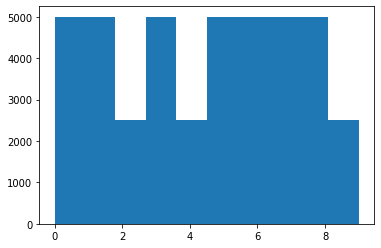

In [9]:
import matplotlib.pyplot as plt

# plot data labels
plt.hist(y_train_removed.flatten())

## Stacked AutoEncoder

#### Load AE models weight

In [21]:
# Batch Norm Model
def create_AE01_model(k_size):
    input_img = Input(shape=(32, 32, 3))  # 0
    conv1 = Conv2D(64, (k_size, k_size), padding='same', name="Dense_AE01_1")(input_img) # 1
    conv1 = BatchNormalization(name="BN_AE01_1")(conv1) # 2
    conv1 = Activation('relu', name="Relu_AE01_1")(conv1) # 3
        
    decoded = Conv2D(3, (k_size, k_size), padding='same', name="Dense_AE01_2")(conv1) # 4
    decoded = BatchNormalization(name="BN_AE01_2")(decoded) # 5
    decoded = Activation('relu', name="Relu_AE01_2")(decoded) # 6
    return Model(input_img, decoded)

# Batch Norm Model
def create_AE02_model(k_size):
    input_img = Input(shape=(32, 32, 64))  # 0
    conv1 = Conv2D(128, (k_size, k_size), padding='same', name="Dense_AE02_1")(input_img) # 1
    conv1 = BatchNormalization(name="BN_AE02_1")(conv1) # 2
    conv1 = Activation('relu', name="Relu_AE02_1")(conv1) # 3
    pool1 = MaxPooling2D(name="Pool_AE02_1")(conv1)  # 4
    
    unpool1 = UpSampling2D(name="Unpool_AE02_1")(pool1)  # 5
    decoded = Conv2D(64, (k_size, k_size), padding='same', name="Dense_AE02_2")(unpool1) # 6
    decoded = BatchNormalization(name="BN_AE02_2")(decoded) # 7
    decoded = Activation('relu', name="Relu_AE02_2")(decoded) # 8
    return Model(input_img, decoded)

# Batch Norm Model
def create_AE03_model(k_size):
    input_img = Input(shape=(16, 16, 128))  # 0
    conv1 = Conv2D(256, (k_size, k_size), padding='same', name="Dense_AE03_1")(input_img) # 1
    conv1 = BatchNormalization(name="BN_AE03_1")(conv1) # 2
    conv1 = Activation('relu', name="Relu_AE03_1")(conv1) # 3
    pool1 = MaxPooling2D(name="Pool_AE03_1")(conv1)  # 4
    
    unpool1 = UpSampling2D(name="Unpool_AE03_1")(pool1)  # 5
    decoded = Conv2D(128, (k_size, k_size), padding='same', name="Dense_AE03_2")(unpool1) # 6
    decoded = BatchNormalization(name="BN_AE03_2")(decoded) # 7
    decoded = Activation('relu', name="Relu_AE03_2")(decoded) # 8
    return Model(input_img, decoded)

In [22]:
class AE01():
    def __init__(self, ksize, optimizer):
        self.optimizer = optimizer
        
        self.autoencoder = create_AE01_model(ksize)
        self.encoder = None

    def compile(self, optimizer='adam', loss='binary_crossentropy'):
        self.autoencoder.compile(optimizer=self.optimizer, loss=loss)

    def train(self, x_train=None, x_test=None, epochs=1, batch_size=32, shuffle=True):
        es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
        ae_model_path = '../models/AE/AE01_AE_Best.hdf5'
        cp_cb = ModelCheckpoint(filepath = ae_model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
       
        history = self.autoencoder.fit(x_train, x_train,
                             epochs=epochs,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             callbacks=[es_cb, cp_cb],
                             validation_data=(x_test, x_test))
        
        self.autoencoder.load_weights(ae_model_path)
        
        self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer('Relu_AE01_1').output)
        encode_model_path = '../models/AE/AE01_Encoder_Best.hdf5'
        self.encoder.save(encode_model_path)
        return history
    
    def load_weights(self, ae_model_path):
        self.autoencoder.load_weights(ae_model_path)
        self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer('Relu_AE01_1').output)

        
class AE02():
    def __init__(self, ksize, optimizer):
        self.optimizer = optimizer
        
        self.autoencoder = create_AE02_model(ksize)
        self.encoder = None

    def compile(self, optimizer='adam', loss='binary_crossentropy'):
        self.autoencoder.compile(optimizer=self.optimizer, loss=loss)

    def train(self, x_train=None, x_test=None, epochs=1, batch_size=32, shuffle=True):
        es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
        ae_model_path = '../models/AE/AE02_AE_Best.hdf5'
        cp_cb = ModelCheckpoint(filepath = ae_model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
       
        history = self.autoencoder.fit(x_train, x_train,
                             epochs=epochs,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             callbacks=[es_cb, cp_cb],
                             validation_data=(x_test, x_test))
        
        self.autoencoder.load_weights(ae_model_path)
        
        self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer('Pool_AE02_1').output)
        encode_model_path = '../models/AE/AE02_Encoder_Best.hdf5'
        self.encoder.save(encode_model_path)
        return history

    def load_weights(self, ae_model_path):
        self.autoencoder.load_weights(ae_model_path)
        self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer('Pool_AE02_1').output)
        
class AE03():
    def __init__(self, ksize, optimizer):
        self.optimizer = optimizer
        
        self.autoencoder = create_AE03_model(ksize)
        self.encoder = None

    def compile(self, optimizer='adam', loss='binary_crossentropy'):
        self.autoencoder.compile(optimizer=self.optimizer, loss=loss)

    def train(self, x_train=None, x_test=None, epochs=1, batch_size=32, shuffle=True):
        es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
        ae_model_path = '../models/AE/AE03_AE_Best.hdf5'
        cp_cb = ModelCheckpoint(filepath = ae_model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
       
        history = self.autoencoder.fit(x_train, x_train,
                             epochs=epochs,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             callbacks=[es_cb, cp_cb],
                             validation_data=(x_test, x_test))
        
        self.autoencoder.load_weights(ae_model_path)
        
        self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer('Pool_AE03_1').output)
        encode_model_path = '../models/AE/AE03_Encoder_Best.hdf5'
        self.encoder.save(encode_model_path)
        return history
    
    def load_weights(self, ae_model_path):
        self.autoencoder.load_weights(ae_model_path)
        self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer('Pool_AE03_1').output)

In [23]:
ae_ksize = 3
ae_optimizer = 'rmsprop'
ae01 = AE01(ae_ksize, ae_optimizer)
ae01.load_weights('../models/AE/AE01_AE_Best.hdf5')

ae02 = AE02(ae_ksize, ae_optimizer)
ae02.load_weights('../models/AE/AE02_AE_Best.hdf5')

ae03 = AE03(ae_ksize, ae_optimizer)
ae03.load_weights('../models/AE/AE03_AE_Best.hdf5')

In [41]:
def create_StackedAE01_model(k_size):
    # AE 01 encode
    input_img = Input(shape=(32, 32, 3))  # 0; 32*32*3
    conv1 = Conv2D(64, (k_size, k_size), padding='same', name="Dense_AE01_1")(input_img) # 1; 32*32*64
    conv1 = BatchNormalization(name="BN_AE01_1")(conv1) # 2
    conv1 = Activation('relu', name="Relu_AE01_1")(conv1) # 3

    # AE 02 encode
    conv2 = Conv2D(128, (k_size, k_size), padding='same', name="Dense_AE02_1")(conv1) # 4; 32*32*128
    conv2 = BatchNormalization(name="BN_AE02_1")(conv2) # 5
    conv2 = Activation('relu', name="Relu_AE02_1")(conv2) # 6
    pool1 = MaxPooling2D(name="Pool_AE02_1")(conv2)  # 7; 16*16*128

    # AE 03 encode
    conv3 = Conv2D(256, (k_size, k_size), padding='same', name="Dense_AE03_1")(pool1) # 8; 16*16*256
    conv3 = BatchNormalization(name="BN_AE03_1")(conv3) # 9
    conv3 = Activation('relu', name="Relu_AE03_1")(conv3) # 10
    pool2 = MaxPooling2D(name="Pool_AE03_1")(conv3)  # 11; 8*8*256

    # AE 03 decode
    unpool1 = UpSampling2D(name="Unpool_AE03_1")(pool2)  # 12; 16*16*256
    conv4 = Conv2D(128, (k_size, k_size), padding='same', name="Dense_AE03_2")(unpool1) # 13; 16*16*128
    conv4 = BatchNormalization(name="BN_AE03_2")(conv4) # 14
    conv4 = Activation('relu', name="Relu_AE03_2")(conv4) # 15

    # AE 02 decode 
    unpool2 = UpSampling2D(name="Unpool_AE02_1")(conv4)  # 16; 32*32*128
    conv5 = Conv2D(64, (k_size, k_size), padding='same', name="Dense_AE02_2")(unpool2) # 17; 32*32*64
    conv5 = BatchNormalization(name="BN_AE02_2")(conv5) # 18
    conv5 = Activation('relu', name="Relu_AE02_2")(conv5) # 19

    # AE 01 decode
    decoded = Conv2D(3, (k_size, k_size), padding='same', name="Dense_AE01_2")(conv5) # 20; 32*32*3
    decoded = BatchNormalization(name="BN_AE01_2")(decoded) # 21
    decoded = Activation('relu', name="Relu_AE01_2")(decoded) # 22

    return Model(input_img, decoded)

In [66]:
class StackedAE01:
    def __init__(self, k_size, optimizer):
        self.optimizer = optimizer
        
        self.encoder = None
        self.autoencoder = create_StackedAE01_model(k_size)
        
    def compile(self, loss='binary_crossentropy'):
        self.autoencoder.compile(optimizer=self.optimizer, loss=loss)
        
    def train(self, x_train=None, x_test=None, epochs=1, batch_size=32, shuffle=True):
        es_cb = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')
        ae_model_path = '../models/AE/Stacked01_AE_Best.hdf5'
        cp_cb = ModelCheckpoint(filepath = ae_model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
       
        history = self.autoencoder.fit(x_train, x_train,
                             epochs=epochs,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             callbacks=[es_cb, cp_cb],
                             validation_data=(x_test, x_test))
        
        self.autoencoder.load_weights(ae_model_path)
        
        self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer('Pool_AE03_1').output)
        encode_model_path = '../models/AE/Stacked01_Encoder_Best.hdf5'
        self.encoder.save(encode_model_path)
        return history
    
    def load_weights(self, ae01, ae02, ae03):
        self.autoencoder.layers[1].set_weights(ae01.layers[1].get_weights())
        self.autoencoder.layers[4].set_weights(ae02.layers[1].get_weights())
        self.autoencoder.layers[8].set_weights(ae03.layers[1].get_weights())
        
        self.autoencoder.layers[13].set_weights(ae03.layers[6].get_weights())
        self.autoencoder.layers[17].set_weights(ae02.layers[6].get_weights())
        self.autoencoder.layers[20].set_weights(ae01.layers[4].get_weights())

#### Define StackedAE 01 Hyperparamters

In [46]:
# Hyperparmeter Optimization
def objective1(trial):
    print("Optimize Start")
    
    # filter size
#     k_size = trial.suggest_categorical('ksize', [3, 5, 7]) # 3 or 5 or 7
    k_size = 3

    # batch size
    batch_size = trial.suggest_categorical('batchsize', [32, 64, 128]) # 32 or 64 or 128
    
    # optimizer
    optimizer = trial.suggest_categorical("optimizer", ['adam', 'sgd', 'rmsprop']) # Adam or SGD or RMsprop
    
    # learning rate
#     lr = trial.suggest_loguniform('lr', 1e-5, 1e-1) # 1e-5~1e-1
    
    model = create_StackedAE01_model(k_size)
    model.compile(optimizer=optimizer,
          loss='binary_crossentropy')
    
    history = model.fit(x_train_removed, x_train_removed, epochs=10, batch_size=batch_size, validation_data=(x_test, x_test))
    return min(history.history["val_loss"]) # get min loss

# create study object
study1 = optuna.create_study()

# optimization
study1.optimize(objective1, n_trials=10)
print(study1.best_params)

[I 2021-03-04 10:55:30,008] A new study created in memory with name: no-name-f778a825-efe2-4092-b0a6-174cb7bfb859


Optimize Start
Epoch 1/10
333/333 [==============================] - 326s 979ms/step - loss: 0.9311 - val_loss: 0.7092
Epoch 2/10
333/333 [==============================] - 331s 994ms/step - loss: 0.7281 - val_loss: 0.6849
Epoch 3/10
333/333 [==============================] - 324s 972ms/step - loss: 0.6968 - val_loss: 0.6530
Epoch 4/10
333/333 [==============================] - 322s 967ms/step - loss: 0.5987 - val_loss: 0.5836
Epoch 5/10
333/333 [==============================] - 325s 976ms/step - loss: 0.5775 - val_loss: 0.5787
Epoch 6/10
333/333 [==============================] - 326s 979ms/step - loss: 0.5739 - val_loss: 0.5744
Epoch 7/10
333/333 [==============================] - 327s 983ms/step - loss: 0.5722 - val_loss: 0.5745
Epoch 8/10
333/333 [==============================] - 324s 974ms/step - loss: 0.5709 - val_loss: 0.5731
Epoch 9/10
333/333 [==============================] - 323s 971ms/step - loss: 0.5700 - val_loss: 0.5721
Epoch 10/10
333/333 [============================

[I 2021-03-04 11:49:53,941] Trial 0 finished with value: 0.570265531539917 and parameters: {'batchsize': 128, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.570265531539917.


Optimize Start
Epoch 1/10
665/665 [==============================] - 309s 465ms/step - loss: 0.8970 - val_loss: 0.6388
Epoch 2/10
665/665 [==============================] - 311s 468ms/step - loss: 0.6051 - val_loss: 0.5801
Epoch 3/10
665/665 [==============================] - 310s 466ms/step - loss: 0.5760 - val_loss: 0.5748
Epoch 4/10
665/665 [==============================] - 308s 464ms/step - loss: 0.5728 - val_loss: 0.5725
Epoch 5/10
665/665 [==============================] - 310s 465ms/step - loss: 0.5723 - val_loss: 0.5741
Epoch 6/10
665/665 [==============================] - 310s 467ms/step - loss: 0.5703 - val_loss: 0.5707
Epoch 7/10
665/665 [==============================] - 312s 470ms/step - loss: 0.5685 - val_loss: 0.5701
Epoch 8/10
665/665 [==============================] - 311s 468ms/step - loss: 0.5684 - val_loss: 0.5687
Epoch 9/10
665/665 [==============================] - 310s 467ms/step - loss: 0.5671 - val_loss: 0.5674
Epoch 10/10
665/665 [============================

[I 2021-03-04 12:41:44,868] Trial 1 finished with value: 0.5674350261688232 and parameters: {'batchsize': 64, 'optimizer': 'sgd'}. Best is trial 1 with value: 0.5674350261688232.


Optimize Start
Epoch 1/10
333/333 [==============================] - 329s 987ms/step - loss: 0.9244 - val_loss: 0.6221
Epoch 2/10
333/333 [==============================] - 333s 1s/step - loss: 0.7037 - val_loss: 2.9987
Epoch 3/10
333/333 [==============================] - 338s 1s/step - loss: 0.6633 - val_loss: 0.6101
Epoch 4/10
333/333 [==============================] - 345s 1s/step - loss: 0.6347 - val_loss: 0.7044
Epoch 5/10
333/333 [==============================] - 346s 1s/step - loss: 0.6107 - val_loss: 0.6188
Epoch 6/10
333/333 [==============================] - 347s 1s/step - loss: 0.5809 - val_loss: 0.5753
Epoch 7/10
333/333 [==============================] - 346s 1s/step - loss: 0.5715 - val_loss: 0.5729
Epoch 8/10
333/333 [==============================] - 347s 1s/step - loss: 0.5699 - val_loss: 0.5717
Epoch 9/10
333/333 [==============================] - 346s 1s/step - loss: 0.5688 - val_loss: 0.5741
Epoch 10/10
333/333 [==============================] - 350s 1s/step - los

[I 2021-03-04 13:39:02,728] Trial 2 finished with value: 0.5694714188575745 and parameters: {'batchsize': 128, 'optimizer': 'sgd'}. Best is trial 1 with value: 0.5674350261688232.


Optimize Start
Epoch 1/10
1329/1329 [==============================] - 329s 248ms/step - loss: 0.7745 - val_loss: 0.6058
Epoch 2/10
1329/1329 [==============================] - 331s 249ms/step - loss: 0.5936 - val_loss: 0.6169
Epoch 3/10
1329/1329 [==============================] - 336s 252ms/step - loss: 0.5760 - val_loss: 0.5726
Epoch 4/10
1329/1329 [==============================] - 332s 250ms/step - loss: 0.5715 - val_loss: 0.5705
Epoch 5/10
1329/1329 [==============================] - 334s 251ms/step - loss: 0.5705 - val_loss: 0.6140
Epoch 6/10
1329/1329 [==============================] - 333s 251ms/step - loss: 0.5693 - val_loss: 0.5670
Epoch 7/10
1329/1329 [==============================] - 331s 249ms/step - loss: 0.5675 - val_loss: 0.5662
Epoch 8/10
1329/1329 [==============================] - 332s 250ms/step - loss: 0.5668 - val_loss: 0.5683
Epoch 9/10
1329/1329 [==============================] - 335s 252ms/step - loss: 0.5658 - val_loss: 0.5649
Epoch 10/10
1329/1329 [========

[I 2021-03-04 14:34:31,788] Trial 3 finished with value: 0.5645248889923096 and parameters: {'batchsize': 32, 'optimizer': 'sgd'}. Best is trial 3 with value: 0.5645248889923096.


Optimize Start
Epoch 1/10
333/333 [==============================] - 329s 988ms/step - loss: 0.9286 - val_loss: 0.9196
Epoch 2/10
333/333 [==============================] - 339s 1s/step - loss: 0.6692 - val_loss: 1.0461
Epoch 3/10
333/333 [==============================] - 347s 1s/step - loss: 0.6155 - val_loss: 0.6885
Epoch 4/10
333/333 [==============================] - 347s 1s/step - loss: 0.5899 - val_loss: 0.6099
Epoch 5/10
333/333 [==============================] - 345s 1s/step - loss: 0.5767 - val_loss: 1.5558
Epoch 6/10
333/333 [==============================] - 343s 1s/step - loss: 0.5829 - val_loss: 1.4768
Epoch 7/10
333/333 [==============================] - 345s 1s/step - loss: 0.5758 - val_loss: 0.5843
Epoch 8/10
333/333 [==============================] - 346s 1s/step - loss: 0.5671 - val_loss: 1.4234
Epoch 9/10
333/333 [==============================] - 344s 1s/step - loss: 0.5685 - val_loss: 0.5894
Epoch 10/10
333/333 [==============================] - 344s 1s/step - los

[I 2021-03-04 15:31:51,392] Trial 4 finished with value: 0.5843256115913391 and parameters: {'batchsize': 128, 'optimizer': 'rmsprop'}. Best is trial 3 with value: 0.5645248889923096.


Optimize Start
Epoch 1/10
1329/1329 [==============================] - 340s 256ms/step - loss: 0.8469 - val_loss: 0.6556
Epoch 2/10
1329/1329 [==============================] - 341s 257ms/step - loss: 0.6458 - val_loss: 0.5942
Epoch 3/10
1329/1329 [==============================] - 340s 256ms/step - loss: 0.6266 - val_loss: 0.6047
Epoch 4/10
1329/1329 [==============================] - 341s 256ms/step - loss: 0.6111 - val_loss: 0.5767
Epoch 5/10
1329/1329 [==============================] - 341s 257ms/step - loss: 0.5916 - val_loss: 0.5765
Epoch 6/10
1329/1329 [==============================] - 340s 256ms/step - loss: 0.5756 - val_loss: 0.5696
Epoch 7/10
1329/1329 [==============================] - 339s 255ms/step - loss: 0.5659 - val_loss: 0.5776
Epoch 8/10
1329/1329 [==============================] - 337s 254ms/step - loss: 0.5615 - val_loss: 0.5674
Epoch 9/10
1329/1329 [==============================] - 336s 253ms/step - loss: 0.5603 - val_loss: 0.5680
Epoch 10/10
1329/1329 [========

[I 2021-03-04 16:28:26,726] Trial 5 finished with value: 0.5673862099647522 and parameters: {'batchsize': 32, 'optimizer': 'adam'}. Best is trial 3 with value: 0.5645248889923096.


Optimize Start
Epoch 1/10
1329/1329 [==============================] - 340s 256ms/step - loss: 0.7183 - val_loss: 0.8037
Epoch 2/10
1329/1329 [==============================] - 334s 251ms/step - loss: 0.6236 - val_loss: 0.5897
Epoch 3/10
1329/1329 [==============================] - 334s 252ms/step - loss: 0.5750 - val_loss: 0.5748
Epoch 4/10
1329/1329 [==============================] - 334s 252ms/step - loss: 0.5671 - val_loss: 0.5830
Epoch 5/10
1329/1329 [==============================] - 344s 259ms/step - loss: 0.5657 - val_loss: 0.5680
Epoch 6/10
1329/1329 [==============================] - 351s 264ms/step - loss: 0.5820 - val_loss: 0.7305
Epoch 7/10
1329/1329 [==============================] - 343s 258ms/step - loss: 0.5648 - val_loss: 0.5683
Epoch 8/10
1329/1329 [==============================] - 335s 252ms/step - loss: 0.5599 - val_loss: 0.5563
Epoch 9/10
1329/1329 [==============================] - 336s 253ms/step - loss: 0.5580 - val_loss: 0.5688
Epoch 10/10
1329/1329 [========

[I 2021-03-04 17:24:58,458] Trial 6 finished with value: 0.55632483959198 and parameters: {'batchsize': 32, 'optimizer': 'rmsprop'}. Best is trial 6 with value: 0.55632483959198.


Optimize Start
Epoch 1/10
333/333 [==============================] - 348s 1s/step - loss: 0.9078 - val_loss: 0.6451
Epoch 2/10
333/333 [==============================] - 347s 1s/step - loss: 0.6720 - val_loss: 0.5989
Epoch 3/10
333/333 [==============================] - 348s 1s/step - loss: 0.6035 - val_loss: 0.6148
Epoch 4/10
333/333 [==============================] - 349s 1s/step - loss: 0.6376 - val_loss: 0.6071
Epoch 5/10
333/333 [==============================] - 348s 1s/step - loss: 0.6072 - val_loss: 0.7238
Epoch 6/10
333/333 [==============================] - 348s 1s/step - loss: 0.6405 - val_loss: 0.5976
Epoch 7/10
333/333 [==============================] - 348s 1s/step - loss: 0.6180 - val_loss: 0.6491
Epoch 8/10
333/333 [==============================] - 350s 1s/step - loss: 0.5858 - val_loss: 0.6162
Epoch 9/10
333/333 [==============================] - 349s 1s/step - loss: 0.6115 - val_loss: 0.5896
Epoch 10/10
333/333 [==============================] - 348s 1s/step - loss: 

[I 2021-03-04 18:23:13,204] Trial 7 finished with value: 0.5895568132400513 and parameters: {'batchsize': 128, 'optimizer': 'adam'}. Best is trial 6 with value: 0.55632483959198.


Optimize Start
Epoch 1/10
665/665 [==============================] - 332s 500ms/step - loss: 0.9319 - val_loss: 0.6908
Epoch 2/10
665/665 [==============================] - 332s 499ms/step - loss: 0.6110 - val_loss: 0.5866
Epoch 3/10
665/665 [==============================] - 333s 500ms/step - loss: 0.5788 - val_loss: 0.5766
Epoch 4/10
665/665 [==============================] - 331s 497ms/step - loss: 0.5747 - val_loss: 0.5746
Epoch 5/10
665/665 [==============================] - 334s 502ms/step - loss: 0.5720 - val_loss: 0.5725
Epoch 6/10
665/665 [==============================] - 332s 499ms/step - loss: 0.5717 - val_loss: 0.5720
Epoch 7/10
665/665 [==============================] - 333s 501ms/step - loss: 0.5695 - val_loss: 0.5699
Epoch 8/10
665/665 [==============================] - 333s 501ms/step - loss: 0.5692 - val_loss: 0.5692
Epoch 9/10
665/665 [==============================] - 334s 502ms/step - loss: 0.5677 - val_loss: 0.5682
Epoch 10/10
665/665 [============================

[I 2021-03-04 19:18:45,558] Trial 8 finished with value: 0.5681878328323364 and parameters: {'batchsize': 64, 'optimizer': 'sgd'}. Best is trial 6 with value: 0.55632483959198.


Optimize Start
Epoch 1/10
665/665 [==============================] - 336s 506ms/step - loss: 0.8888 - val_loss: 0.6688
Epoch 2/10
665/665 [==============================] - 327s 492ms/step - loss: 0.6020 - val_loss: 0.5804
Epoch 3/10
665/665 [==============================] - 326s 490ms/step - loss: 0.5752 - val_loss: 0.5745
Epoch 4/10
665/665 [==============================] - 323s 485ms/step - loss: 0.5725 - val_loss: 0.5729
Epoch 5/10
665/665 [==============================] - 323s 486ms/step - loss: 0.5705 - val_loss: 0.5724
Epoch 6/10
665/665 [==============================] - 323s 486ms/step - loss: 0.5692 - val_loss: 0.5698
Epoch 7/10
665/665 [==============================] - 325s 488ms/step - loss: 0.5681 - val_loss: 0.5703
Epoch 8/10
665/665 [==============================] - 325s 488ms/step - loss: 0.5673 - val_loss: 0.5686
Epoch 9/10
665/665 [==============================] - 325s 488ms/step - loss: 0.5671 - val_loss: 0.5697
Epoch 10/10
665/665 [============================

[I 2021-03-04 20:13:08,360] Trial 9 finished with value: 0.5678291320800781 and parameters: {'batchsize': 64, 'optimizer': 'sgd'}. Best is trial 6 with value: 0.55632483959198.


{'batchsize': 32, 'optimizer': 'rmsprop'}


In [47]:
print(f'Auto Encoder 01 the best batch size is {study1.best_params["batchsize"]} \nand best optimizer is {study1.best_params["optimizer"]}')

Auto Encoder 01 the best batch size is 32 
and best optimizer is rmsprop


#### Train StackedAE 01 by opmized hyperparameters

In [67]:
stack01 = StackedAE01(ae_ksize, 'rmsprop')
stack01.compile()
stack01.load_weights(ae01.autoencoder, ae02.autoencoder, ae03.autoencoder)
stack01.autoencoder.summary()

Model: "functional_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
Dense_AE01_1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
BN_AE01_1 (BatchNormalizatio (None, 32, 32, 64)        256       
_________________________________________________________________
Relu_AE01_1 (Activation)     (None, 32, 32, 64)        0         
_________________________________________________________________
Dense_AE02_1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
BN_AE02_1 (BatchNormalizatio (None, 32, 32, 128)       512       
_________________________________________________________________
Relu_AE02_1 (Activation)     (None, 32, 32, 128)     

Epoch 1/100
1328/1329 [============================>.] - ETA: 0s - loss: 0.6535
Epoch 00001: val_loss improved from inf to 0.59478, saving model to ../models/AE\Stacked01_AE_Best.hdf5
1329/1329 [==============================] - 334s 252ms/step - loss: 0.6535 - val_loss: 0.5948
Epoch 2/100
1328/1329 [============================>.] - ETA: 0s - loss: 0.5898
Epoch 00002: val_loss improved from 0.59478 to 0.59006, saving model to ../models/AE\Stacked01_AE_Best.hdf5
1329/1329 [==============================] - 338s 254ms/step - loss: 0.5898 - val_loss: 0.5901
Epoch 3/100
1328/1329 [============================>.] - ETA: 0s - loss: 0.5705
Epoch 00003: val_loss improved from 0.59006 to 0.57039, saving model to ../models/AE\Stacked01_AE_Best.hdf5
1329/1329 [==============================] - 334s 251ms/step - loss: 0.5705 - val_loss: 0.5704
Epoch 4/100
1329/1329 [==============================] - ETA: 0s - loss: 0.5679
Epoch 00004: val_loss did not improve from 0.57039
1329/1329 [=============

Text(0.5, 0, 'epoch')

<Figure size 432x288 with 0 Axes>

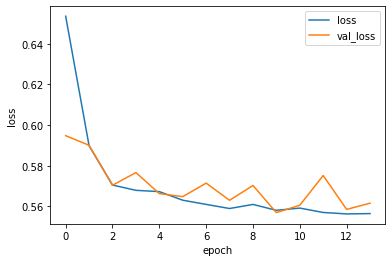

In [68]:
# train
stack01_epochs = 100
stack01_batch_size = 32
Stack01_history = stack01.train(x_train_removed, x_test, stack01_epochs, stack01_batch_size)

# plot training
Stack01_hist_df = pd.DataFrame(Stack01_history.history)

plt.figure()
Stack01_hist_df[['loss', 'val_loss']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')

In [75]:
print(f'StackedAE01 minimum validation loss is {min(Stack01_history.history["val_loss"])}')

StackedAE01 minimum validation loss is 0.5569485425949097


#### Decode Images

In [69]:
# Decode
decoded_imgs = stack01.autoencoder.predict(x_test)

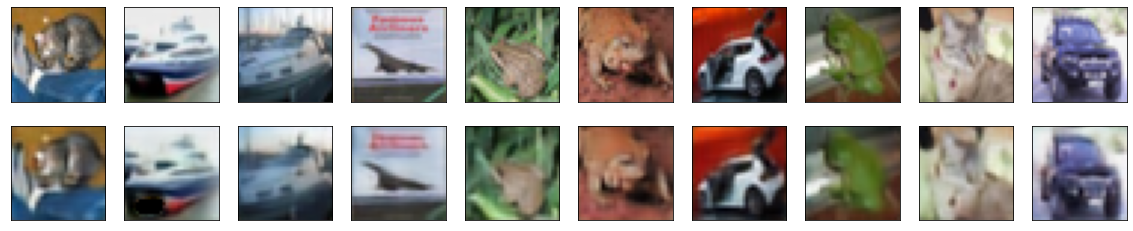

In [70]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()